# Решение для соревнования [[SF-DST] Booking reviews](https://www.kaggle.com/competitions/sf-booking) - Прогнозирование рейтинга отеля на Booking

Начнём проект с загрузки всех необходимых для работы библиотек. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Библиотека для работы с обработкой естественного языка
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_theme("notebook")
%matplotlib inline

# Инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Библиотека для кодирования признаков:
import category_encoders as ce

# Библиотека для нормализации и стандартизации
from sklearn import preprocessing

# Модуль предоставляющий статистические функции
from scipy import stats

# Инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor

# Инструменты для оценки точности модели
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Максимка\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Знакомимся с данными

In [6]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [10]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [11]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [14]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train], axis=0, sort=False, ignore_index=True) # объединяем

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Очистка данных

Произведём поиск дубликатов и пропусков, затем обработаем их.

### Поиск дубликатов и их удаление

Так как удалять дубликаты из общего датасета не рекомендуется, поэтому удалим их из тренировочного и потом сформируем новый общий датасет без дубликатов.

In [16]:
df_train.duplicated().sum() # кол-во дубликатов в тренировочной выборке

307

In [17]:
df_train.drop_duplicates(inplace=True)

In [18]:
# Объединяем тренировочную выборку без дубликатов с исходной тестовой выборкой
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

### Поиск пропусков и работа с ними

In [19]:
df = data.copy()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Видно пропуски у двух признаков lng и lat - это коорднинаты местоположения гостиницы

Выясним количество отелей с отсутствующими координатами

In [21]:
null_row = df[df['lat'].isnull() | df['lng'].isnull()][['hotel_name', 'hotel_address']]
null_row.nunique()

hotel_name       17
hotel_address    17
dtype: int64

Только у 17 отелей пропущены координаты, это не много, поэтому можно обработать эти пропуски вручную.  

Выведем названия и адреса отелей с отсутствующими координатами

In [22]:
null_list = null_row.value_counts()
null_list

hotel_name                                        hotel_address                                              
Fleming s Selection Hotel Wien City               Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Hotel City Central                                Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            563
Hotel Atlanta                                     W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       389
Maison Albar Hotel Paris Op ra Diamond            4 rue de la P pini re 8th arr 75008 Paris France               290
Hotel Daniel Vienna                               Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
Hotel Pension Baron am Schottentor                W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          223
Austria Trend Hotel Schloss Wilhelminenberg Wien  Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Derag Livinghotel Kaiser Franz Joseph Vienna      Sieveringer Stra e 4 

Найдём координаты этих отелей в интернете и создадим словарь с координатами каждого из них.  
Далее заменим пустые значения на верные координаты.

In [23]:
coord_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

In [24]:
df['lat'] = df.apply(lambda x: coord_dict[x['hotel_name']][0] if pd.isnull(x['lat']) else x['lat'], axis=1).astype('float64')
df['lng'] = df.apply(lambda x: coord_dict[x['hotel_name']][1] if pd.isnull(x['lng']) else x['lng'], axis=1).astype('float64')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

## Разведывательный анализ

### Рабта с категориальными признаками

#### "hotel_address"

Выделим признаки 'city' и 'country'

In [26]:
df['city'] = df['hotel_address'].apply(lambda x: 'London' if 'United' in x.split()[-2] else x.split()[-2])
df['country'] = df['hotel_address'].apply(lambda x: 'United Kingdom' if 'United' in x.split()[-2] else x.split()[-1])

In [27]:
df['city'].value_counts()

city
London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: count, dtype: int64

In [28]:
df['country'].value_counts()

country
United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: count, dtype: int64

Получили, что в выборке каждая страна представлена 1 городом

Оставим признак 'country' в нашем датасете, а признаки 'city' и 'hotel_address' удалим

In [29]:
df.drop('city', axis=1, inplace=True)
df.drop('hotel_address', axis=1, inplace=True)

Произведём кодирование признака 'country' методом OneHotEncoding

In [30]:
df = pd.get_dummies(df, columns = ['country'])

In [31]:
df.head()

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,days_since_review,lat,lng,sample,country_Austria,country_France,country_Italy,country_Netherlands,country_Spain,country_United Kingdom
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,531 day,51.507894,-0.143671,1,False,False,False,False,False,True
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,203 day,51.521009,-0.123097,1,False,False,False,False,False,True
2,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,...,289 day,48.845377,2.325643,1,False,True,False,False,False,False
3,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,...,681 day,48.888697,2.394540,1,False,True,False,False,False,False
4,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,...,516 day,52.385601,4.847060,1,False,False,False,True,False,False


#### "review_date"

Выделим признак 'month'

In [32]:
# приводим к формату datetime
df['review_date'] = pd.to_datetime(df['review_date']) # приводим к формату datetime

In [33]:
df['review_month'] = df['review_date'].dt.month

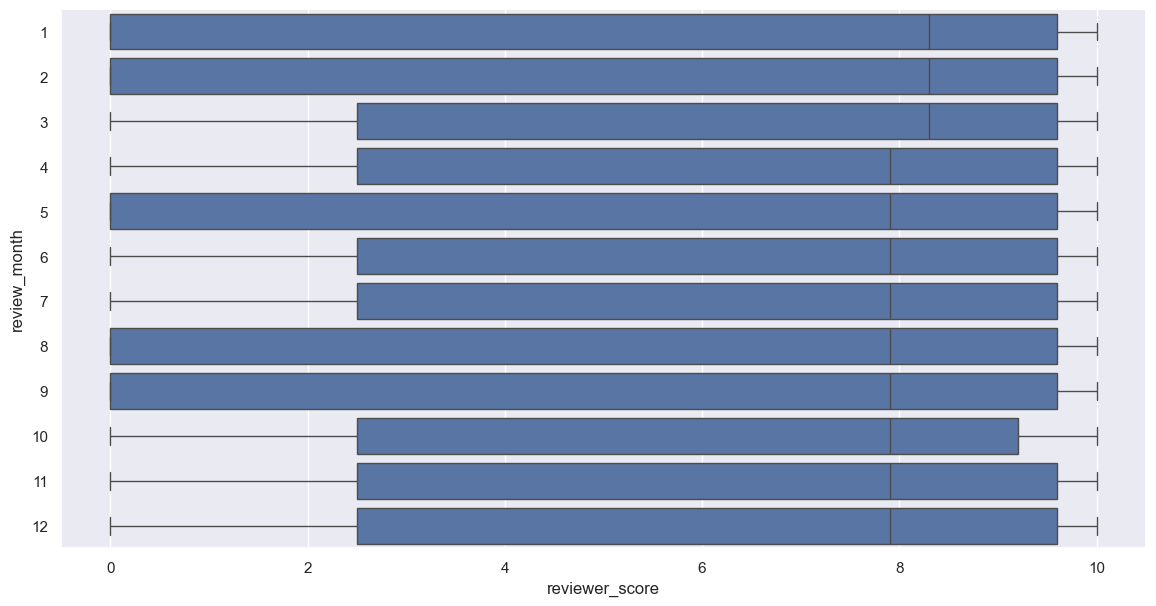

In [34]:
# визуализируем зависимость 'reviewer_score' от 'review_month'
fig = plt.figure(figsize = (14,7))
barplot = sns.boxplot(data=df, x='reviewer_score', y='review_month', orient='h')

Из графика видно, что меданы с 4 по 12 месяц одинаковы, так же равны медианы у первых трех месяцев.  
Считаю, что достаточно будет выделить признак принадлежности к первому кварталу.

In [35]:
df['quarter'] = df['review_date'].dt.quarter
df['quarter'] = df['quarter'].apply(lambda x: 1 if x==1 else 0)

In [36]:
# удалим признаки 'review_month' и 'review_date'
df = df.drop(['review_date', 'review_month'], axis=1)

#### "hotel_name"

Считаю, что название отеля не влияет на оценку и выделить какие-то новые признаки из него невозможно.

In [37]:
# Удалим этот признак
df = df.drop('hotel_name', axis=1)

#### "reviewer_nationality"

In [38]:
df['reviewer_nationality'].value_counts()

reviewer_nationality
 United Kingdom               245165
 United States of America      35390
 Australia                     21663
 Ireland                       14820
 United Arab Emirates          10230
                               ...  
 Guinea                            1
 Tuvalu                            1
 Comoros                           1
 Anguilla                          1
 Cape Verde                        1
Name: count, Length: 227, dtype: int64

В выборке преставлены 227 уникальных национальностей. Думаю, что для анализа достаточно будет десяти с самым большим количеством отзывов.

In [39]:
df_top_10 = df['reviewer_nationality'].value_counts().nlargest(10)

In [40]:
df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x if x in df_top_10 else 'other')

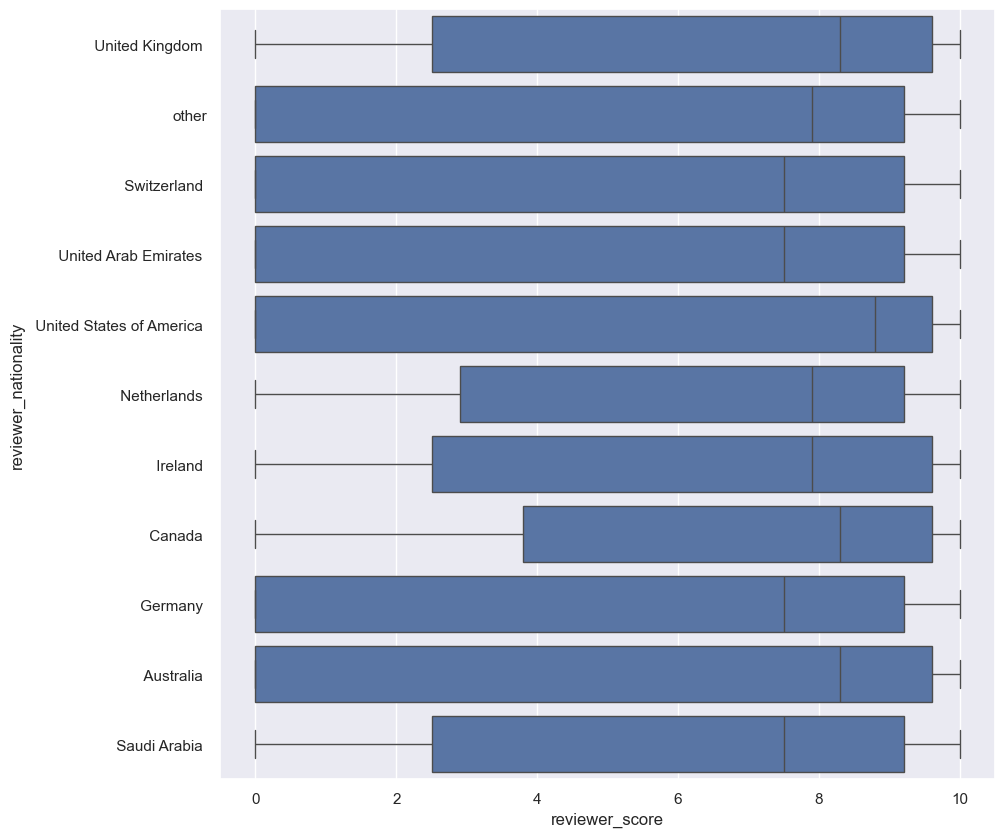

In [41]:
# визуализируем зависимость 'reviewer_score' от 'reviewer_nationality'
fig = plt.figure(figsize = (10,10))
barplot = sns.boxplot(data=df, x='reviewer_score', y='reviewer_nationality', orient='h')

In [42]:
# закодируем новый признак национальности оставившего отзыв
df = pd.get_dummies(df, columns = ['reviewer_nationality'], dtype=int)

#### "review_total_positive_word_counts" & "review_total_negative_word_counts"

Создадим из этих двух признаков новый признак следующим образом, если позитивный отзыв длиннее негативного ставим 1, в противном случае ставим 0.

In [43]:
df['pos_or_neg'] = df.apply(lambda x: 1 if x['review_total_positive_word_counts'] >= x['review_total_negative_word_counts'] else 0, axis=1)

#### "negative_review"

Для анализа отзывов воспользуемся инструментом из библиотеки *vaderSentiment*, который оценивает эмоциональную окраску (тональность) текста.  
Но сначала создадим список самых распространенных отрицательных слов которые могут встречаться в отзывах для отелей.

In [44]:
negative_words = [
    'dirty', 'filthy', 'broken', 'stained', 'smelly', 'rude', 'unprofessional',
    'awful', 'terrible', 'horrible', 'disgusting', 'noisy', 'uncomfortable',
    'worst', 'disappointing', 'poor', 'cold', 'tasteless', 'inedible',
    'overpriced', 'unsafe', 'scam', 'bedbugs', 'cockroaches', 'canceled',
    'misleading', 'lied', 'hairs', 'stains', 'unflushed', 'lack', 'missing'
]

In [45]:
# загружаем инструмент оценки
sia = SentimentIntensityAnalyzer()

In [46]:
# добавим признак с оценкой эмоциональной окраски отзыва
df['negative_sia'] = df['negative_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [47]:
# Находим слова в самых негативных отзывах
very_negative = df[df['negative_sia'] < -0.5]['negative_review']
all_words = ' '.join(very_negative).lower().split()
freq_dist = pd.Series(all_words).value_counts()

In [48]:
# Создадим список из 20 негативных слов, которые встречаются в нашей выборке для признака 'negative_review'
top_impact_words = freq_dist[freq_dist.index.isin(negative_words)]
neg_words = top_impact_words.index.tolist()[:20]
print(neg_words)

['poor', 'noisy', 'dirty', 'rude', 'uncomfortable', 'cold', 'broken', 'terrible', 'disappointing', 'worst', 'awful', 'lack', 'horrible', 'missing', 'disgusting', 'overpriced', 'unprofessional', 'stained', 'stains', 'misleading']


In [49]:
#создаем новые признаки на основе сформированного списка
for word in neg_words:
    df['neg_'+word] = df['negative_review'].apply(lambda x: 1 if word in x else 0)

In [50]:
#удаляем признак "negative_review"
df.drop('negative_review', axis=1, inplace=True)

#### "positive_review"

Повторяем те же действия как и с предыдущим столбцом.

In [51]:
# создадим список самых распространенных положительных слов которые могут встречаться в отзывах для отелей.
positive_words = [
    'excellent', 'amazing', 'wonderful', 'fantastic', 'great', 'perfect',
    'awesome', 'beautiful', 'lovely', 'outstanding', 'superb', 'fabulous',
    'terrific', 'brilliant', 'exceptional', 'pleasant', 'comfortable', 'cozy',
    'clean', 'spacious', 'modern', 'stylish', 'luxurious', 'elegant', 'friendly',
    'helpful', 'attentive', 'professional', 'tasty', 'fresh', 'enjoyable', 
    'relaxing', 'peaceful', 'quiet', 'convenient', 'affordable', 'value',
    'memorable', 'highly recommend'
]

In [52]:
# добавим признак с оценкой эмоциональной окраски отзыва
df['positive_sia'] = df['positive_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [53]:
# Находим слова в самых позитивных отзывах
very_positive = df[df['positive_sia'] > 0.5]['positive_review']
all_words_p = ' '.join(very_positive).lower().split()
freq_dist_p = pd.Series(all_words_p).value_counts()

In [54]:
# Создадим список из 20 позитивных слов, которые встречаются в нашей выборке для признака 'positive_review'
top_impact_words_p = freq_dist_p[freq_dist_p.index.isin(positive_words)]
pos_words = top_impact_words_p.index.tolist()[:20]
print(pos_words)

['great', 'friendly', 'helpful', 'excellent', 'clean', 'comfortable', 'lovely', 'perfect', 'amazing', 'quiet', 'fantastic', 'modern', 'beautiful', 'spacious', 'value', 'wonderful', 'pleasant', 'convenient', 'superb', 'brilliant']


In [55]:
#создаем новые признаки на основе сформированного списка
for word in pos_words:
    df['pos_'+word] = df['positive_review'].apply(lambda x: 1 if word in x else 0)

In [56]:
#удаляем признак "positive_review"
df.drop('positive_review', axis=1, inplace=True)

#### "tags"

Посмотрим сколько уникальных тегов представлено в выборке.

In [57]:
#напишем функцию для создания словаря с тегами
dict_tags = dict()
def func_dict_tags(arg):
    arg = arg[2:-2]
    tmp = arg.strip().split(' \', \' ')
    for i in tmp:
        if i not in dict_tags:
            dict_tags[i] = 1
        else:
            dict_tags[i] +=1

In [58]:
# создаем словарь с тегами и частотой их употребления
df['tags'].apply(func_dict_tags)

0         None
1         None
2         None
3         None
4         None
          ... 
515426    None
515427    None
515428    None
515429    None
515430    None
Name: tags, Length: 515431, dtype: object

Воспользуемся созданным словарем и создадим 20 признаков на основе 20 самых популярных тегов.

In [59]:
list_tag = dict(sorted(dict_tags.items(), key=lambda x:x[1], reverse=True)[0:20])
list_tag = list(list_tag.keys())

In [60]:
#создаем новые признаки
for tag in list_tag:
    df['tag_'+tag] = df['tags'].apply(lambda x: 1 if tag in x else 0)

In [61]:
#удаляем признак "tags"
df.drop('tags', axis=1, inplace=True)

#### "days_since_review"

Здесь оставим только числа

In [62]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x.split()[0]))

### Рабта с числовыми признаками.

In [63]:
df.nunique()

additional_number_of_scoring          480
average_score                          34
review_total_negative_word_counts     402
total_number_of_reviews              1142
review_total_positive_word_counts     365
                                     ... 
tag_Deluxe Double Room                  2
tag_Double or Twin Room                 2
tag_Stayed 5 nights                     2
tag_Standard Double or Twin Room        2
tag_Classic Double Room                 2
Length: 92, dtype: int64

In [64]:
df.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'lat', 'lng', 'sample', 'country_Austria',
       'country_France', 'country_Italy', 'country_Netherlands',
       'country_Spain', 'country_United Kingdom', 'quarter',
       'reviewer_nationality_ Australia ', 'reviewer_nationality_ Canada ',
       'reviewer_nationality_ Germany ', 'reviewer_nationality_ Ireland ',
       'reviewer_nationality_ Netherlands ',
       'reviewer_nationality_ Saudi Arabia ',
       'reviewer_nationality_ Switzerland ',
       'reviewer_nationality_ United Arab Emirates ',
       'reviewer_nationality_ United Kingdom ',
       'reviewer_nationality_ United States of America ',
       'reviewer_nationality_other', 'pos_or_neg', 'negative_sia', 'neg_poor',
       'neg_noisy', 'neg_dirty', 'n

Выделим непрерывные числовые признаки

In [65]:
num_cols = ['additional_number_of_scoring',
            'average_score',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'lat', 'lng',
            'negative_sia',
            'positive_sia'
]

Выделим категориальные числовые признаки

In [66]:
cat_cols = ['country_Austria', 'country_France', 'country_Italy',
            'country_Netherlands', 'country_Spain',
            'country_United Kingdom', 'quarter',
            'reviewer_nationality_ Australia ', 'reviewer_nationality_ Canada ',
            'reviewer_nationality_ Germany ', 'reviewer_nationality_ Ireland ',
            'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Saudi Arabia ',
            'reviewer_nationality_ Switzerland ', 'reviewer_nationality_ United Arab Emirates ',
            'reviewer_nationality_ United Kingdom ', 'reviewer_nationality_ United States of America ',
            'reviewer_nationality_other',
            'pos_or_neg', 'neg_poor', 'neg_noisy', 'neg_dirty', 'neg_rude',
            'neg_uncomfortable', 'neg_broken', 'neg_cold', 'neg_terrible',
            'neg_disappointing', 'neg_worst', 'neg_awful', 'neg_lack', 'neg_horrible',
            'neg_missing', 'neg_disgusting', 'neg_overpriced', 'neg_unprofessional',
            'neg_stained', 'neg_stains', 'neg_misleading', 'pos_great', 'pos_friendly',
            'pos_helpful', 'pos_excellent', 'pos_clean', 'pos_comfortable', 'pos_lovely',
            'pos_perfect', 'pos_amazing', 'pos_quiet', 'pos_fantastic', 'pos_modern',
            'pos_beautiful', 'pos_spacious', 'pos_value', 'pos_wonderful', 'pos_pleasant',
            'pos_convenient', 'pos_superb', 'pos_brilliant',
            'tag_Leisure trip', 'tag_Submitted from a mobile device',
            'tag_Couple', 'tag_Stayed 1 night', 'tag_Stayed 2 nights', 'tag_Solo traveler',
            'tag_Stayed 3 nights', 'tag_Business trip', 'tag_Group', 'tag_Family with young children',
            'tag_Stayed 4 nights', 'tag_Double Room', 'tag_Standard Double Room',
            'tag_Superior Double Room', 'tag_Family with older children', 'tag_Deluxe Double Room',
            'tag_Double or Twin Room', 'tag_Stayed 5 nights', 'tag_Standard Double or Twin Room',
            'tag_Classic Double Room'
]

#### Проверка на нормальность

In [67]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


In [68]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

При помощи теста Шапиро-Уилка проверим числовые непрерывные признаки на нормальность:

In [69]:
for i in num_cols:
    print(i)
    result = stats.shapiro(df[i])
    decision_normality(result[1])

additional_number_of_scoring
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
average_score


c:\Python\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
review_total_negative_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
total_number_of_reviews
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
review_total_positive_word_counts
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
total_number_of_reviews_reviewer_has_given
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
days_since_review
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
lat
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
lng
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.

#### Нормализация

Все числовые признаки распределены ненормально. Для их нормализации будем использовать RobustScaler, так как работаем с неочищенными от выбросов данными.

In [70]:
r_scaler = preprocessing.RobustScaler()
df[num_cols] = r_scaler.fit_transform(df[num_cols])

## Отбор признаков

Text(0.5, 1.0, 'Тепловая карта корреляции числовых признаков')

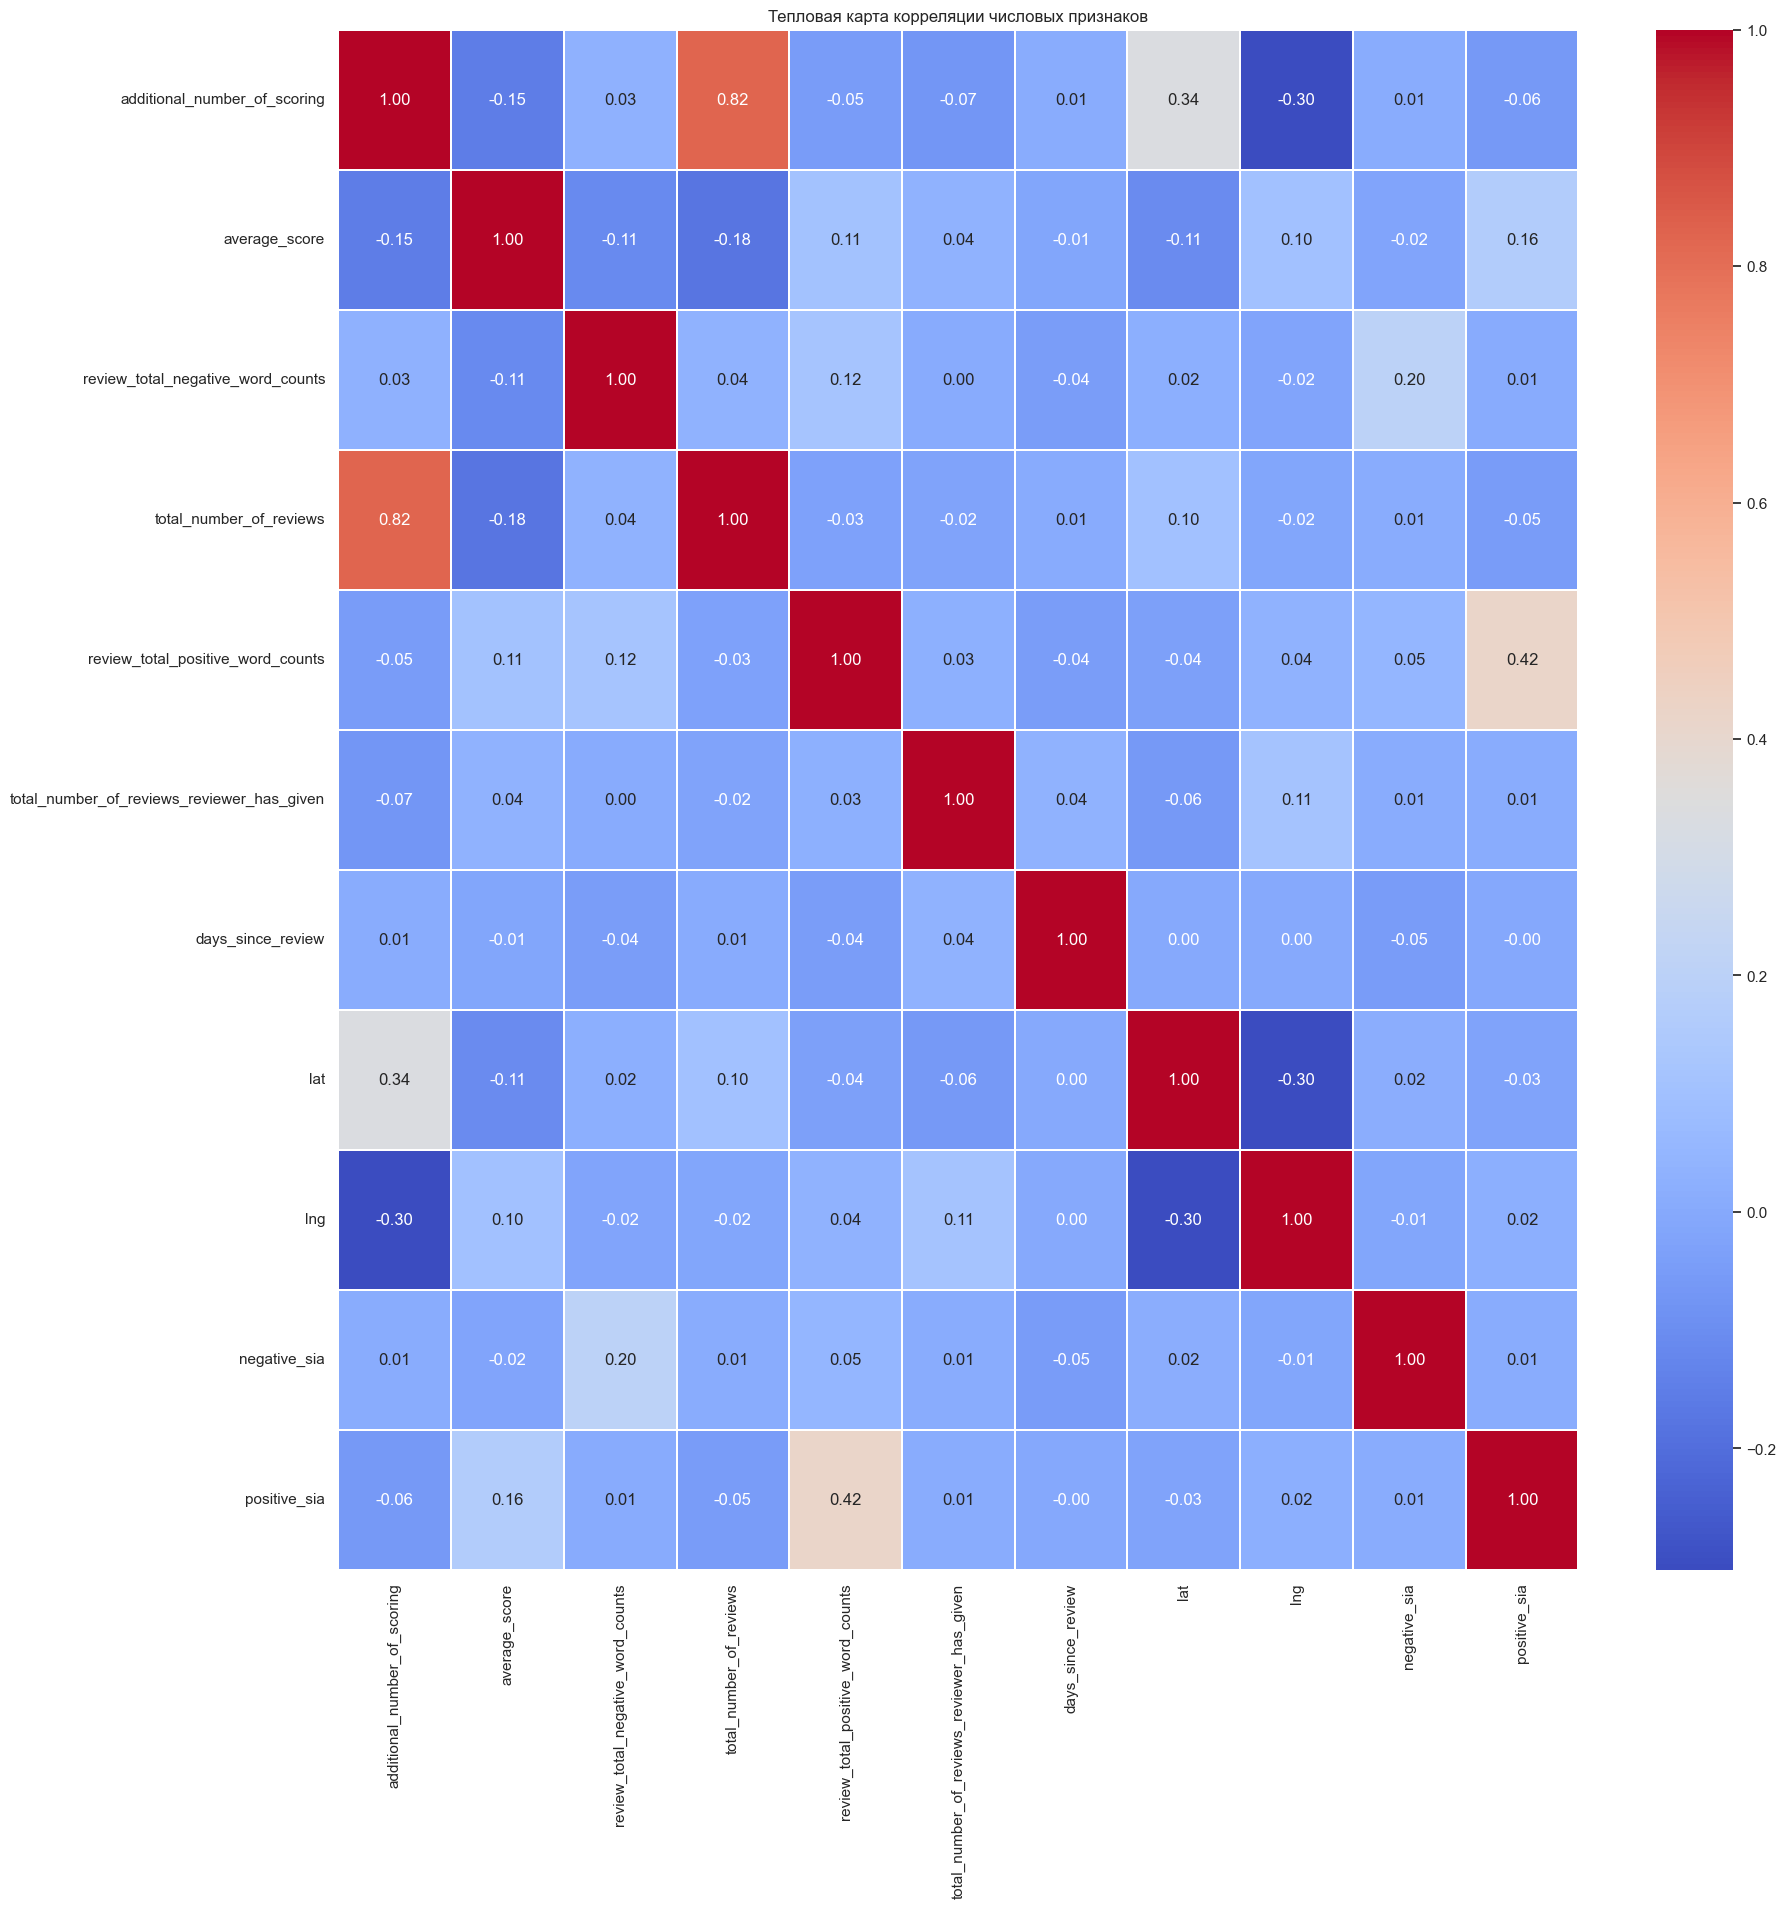

In [71]:
# строим тепловую карту корреляции числовых признаков
fig = plt.figure(figsize = (20,20))
ax = sns.heatmap(df[num_cols].corr(), fmt='.2f', linewidths=.1, cmap='coolwarm', annot=True)
ax.set_title('Тепловая карта корреляции числовых признаков')

Из карты видно, что у двух признаков обнаружена сильная корреляция: 'total_number_of_reviews'(общее количество действительных отзывов об отеле) и 'additional_number_of_scoring'(некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки). 'total_number_of_reviews' оставлю, а 'additional_number_of_scoring' удаляю.

In [72]:
df.drop('additional_number_of_scoring', axis=1, inplace=True)

Построим тепловую карту корреляции категориальных признаков

In [73]:
df_corr = df[cat_cols].corr(method = 'spearman')

Text(0.5, 1.0, 'Тепловая карта корреляции категориальных признаков')

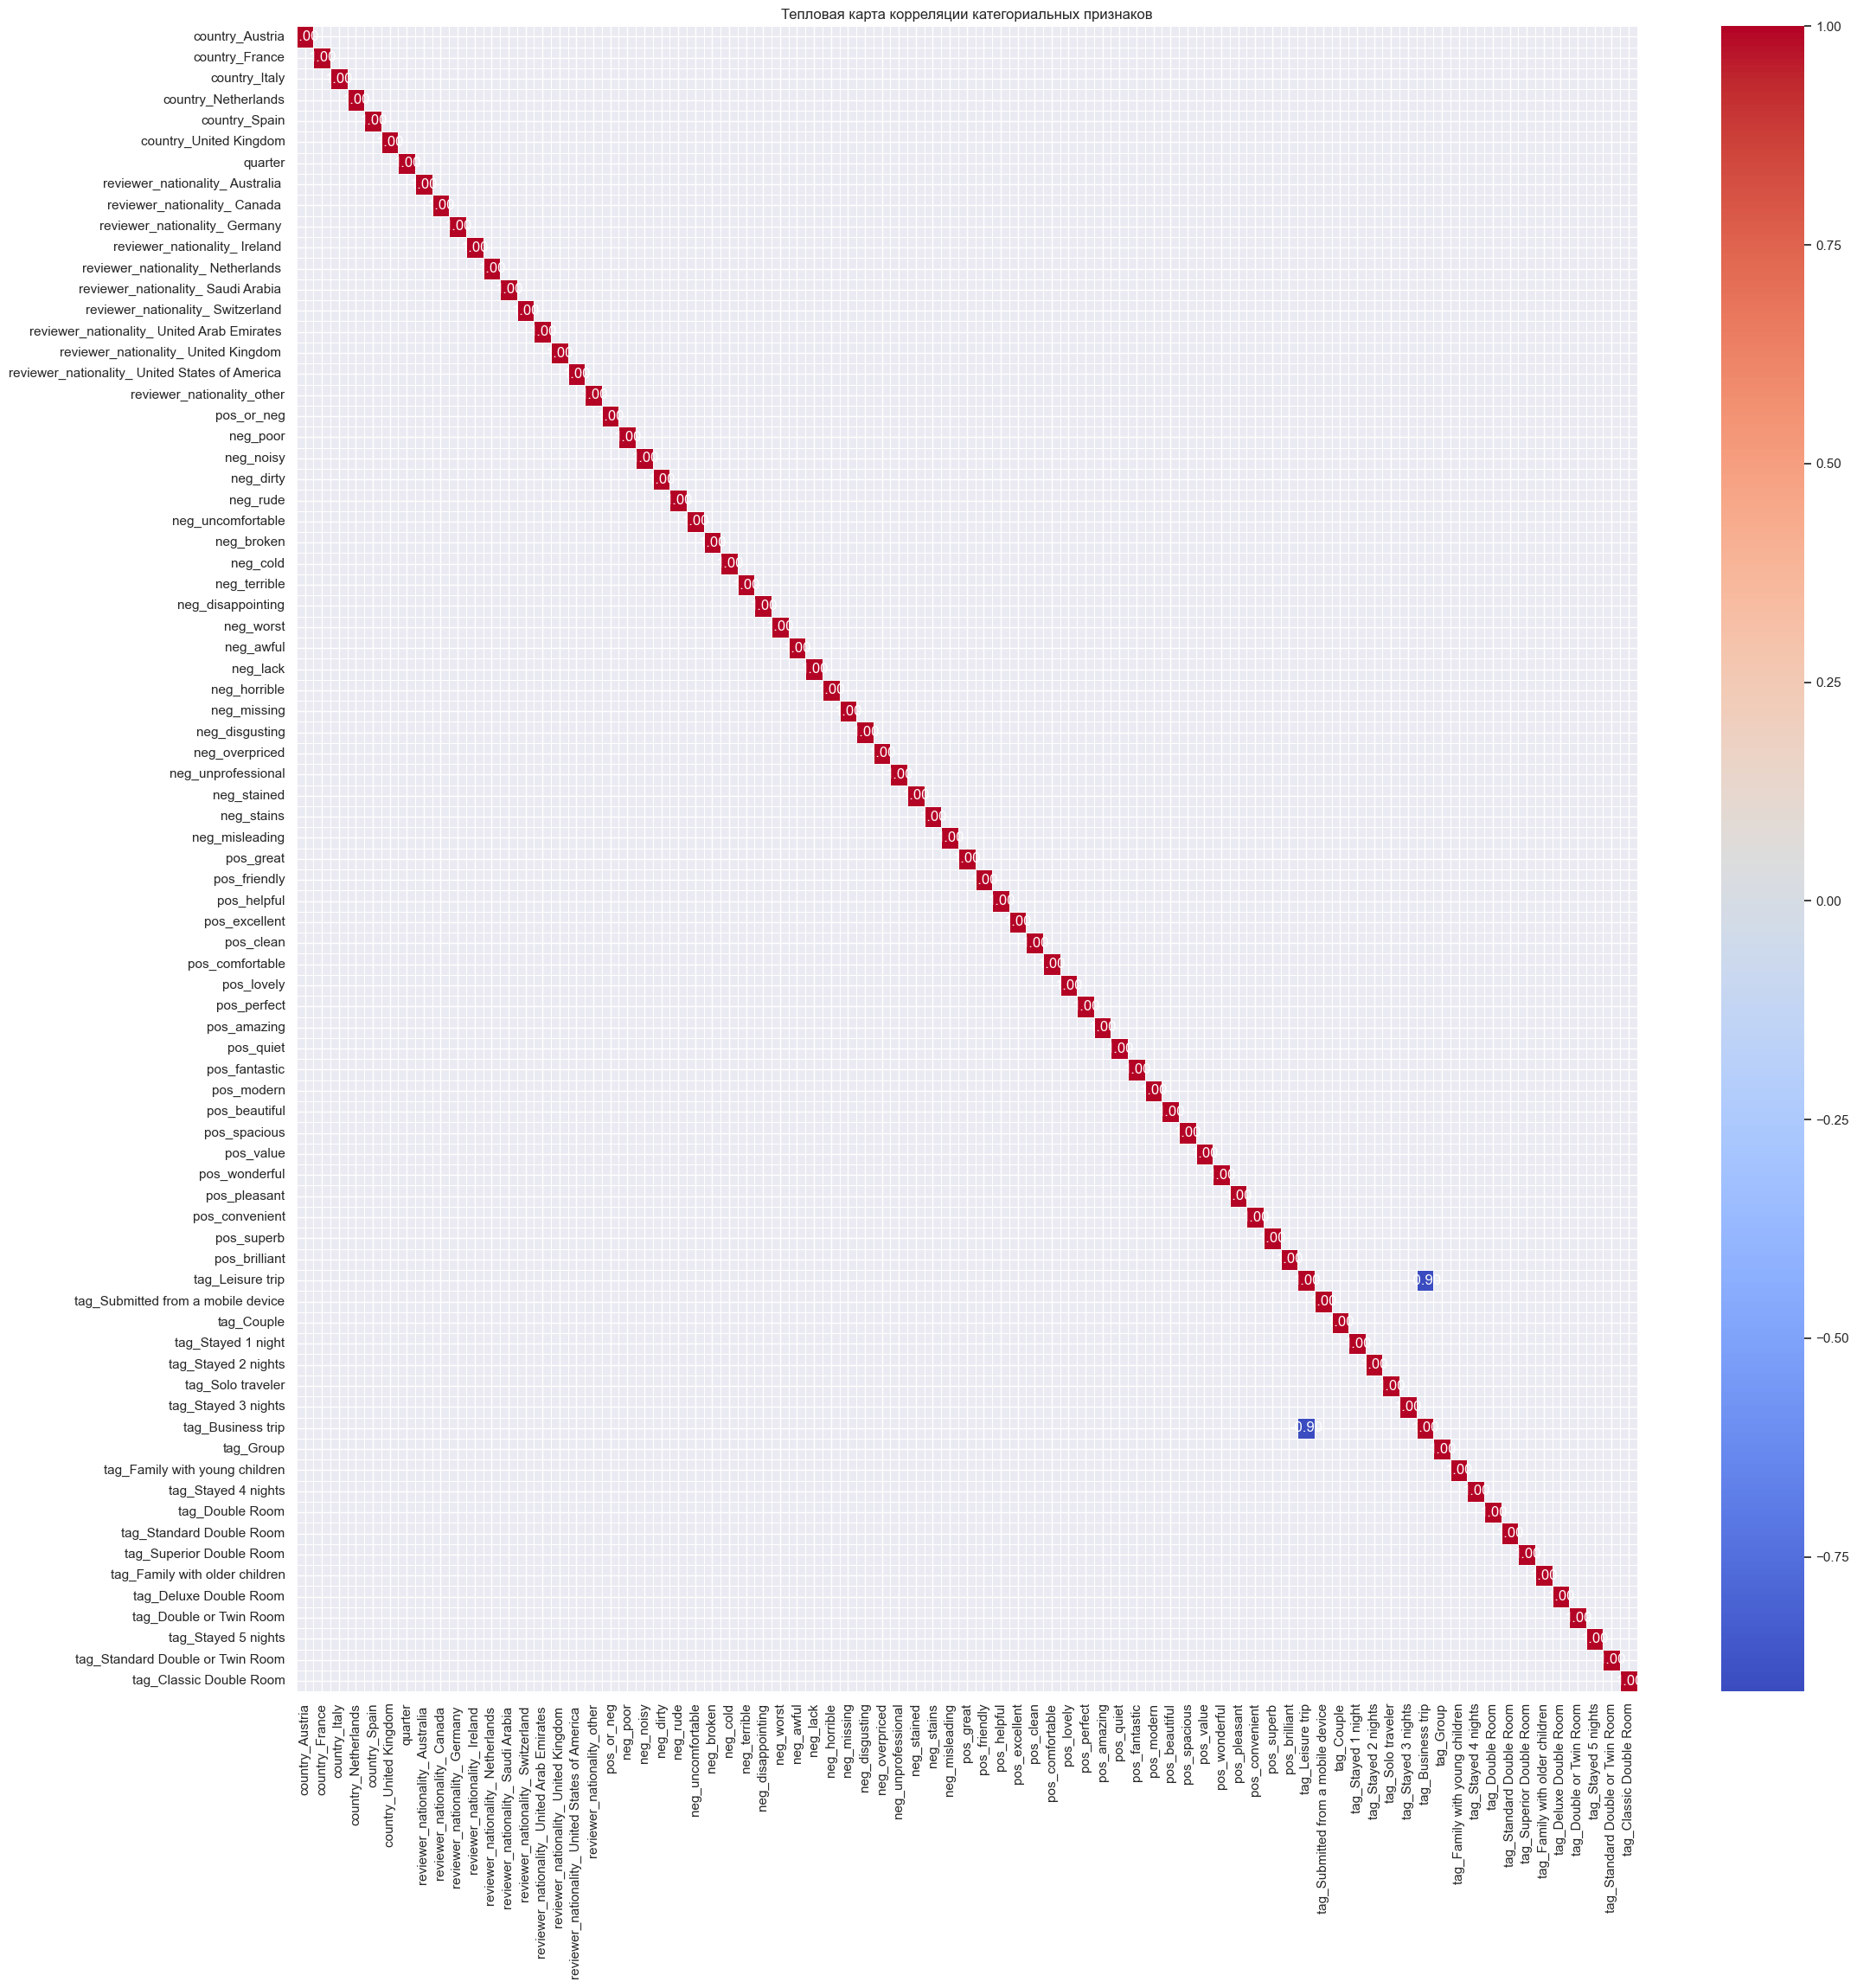

In [74]:
fig = plt.figure(figsize = (25,25))
ax = sns.heatmap(df_corr[0.7<=df_corr.abs()], fmt='.2f', linewidths=.5, cmap='coolwarm', annot=True)
ax.set_title('Тепловая карта корреляции категориальных признаков')

Сильная корреляция между 'tag_Leisure trip' и 'tag_Business trip', тип поездки. Для того чтобы решить какой из этих двух признаков удалить сравним их количество.   

In [75]:
df['tag_Leisure trip'].value_counts()

tag_Leisure trip
1    417538
0     97893
Name: count, dtype: int64

Видно, что большая часть поездок носит туристический характер, значит оставим признак 'tag_Leisure trip', а 'tag_Business trip' удалим.

In [76]:
df.drop('tag_Business trip', axis=1, inplace=True)

Получим следующие признаки которые будем использовать в построении и обучении модели

In [77]:
# числовые признаки
num_cols = ['average_score',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'lat', 'lng',
            'negative_sia',
            'positive_sia'
]

In [78]:
# категориальные признаки
cat_cols = ['country_Austria', 'country_France', 'country_Italy',
            'country_Netherlands', 'country_Spain',
            'country_United Kingdom', 'quarter',
            'reviewer_nationality_ Australia ', 'reviewer_nationality_ Canada ',
            'reviewer_nationality_ Germany ', 'reviewer_nationality_ Ireland ',
            'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Saudi Arabia ',
            'reviewer_nationality_ Switzerland ', 'reviewer_nationality_ United Arab Emirates ',
            'reviewer_nationality_ United Kingdom ', 'reviewer_nationality_ United States of America ',
            'reviewer_nationality_other',
            'pos_or_neg', 'neg_poor', 'neg_noisy', 'neg_dirty', 'neg_rude',
            'neg_uncomfortable', 'neg_broken', 'neg_cold', 'neg_terrible',
            'neg_disappointing', 'neg_worst', 'neg_awful', 'neg_lack', 'neg_horrible',
            'neg_missing', 'neg_disgusting', 'neg_overpriced', 'neg_unprofessional',
            'neg_stained', 'neg_stains', 'neg_misleading', 'pos_great', 'pos_friendly',
            'pos_helpful', 'pos_excellent', 'pos_clean', 'pos_comfortable', 'pos_lovely',
            'pos_perfect', 'pos_amazing', 'pos_quiet', 'pos_fantastic', 'pos_modern',
            'pos_beautiful', 'pos_spacious', 'pos_value', 'pos_wonderful', 'pos_pleasant',
            'pos_convenient', 'pos_superb', 'pos_brilliant',
            'tag_Leisure trip', 'tag_Submitted from a mobile device',
            'tag_Couple', 'tag_Stayed 1 night', 'tag_Stayed 2 nights', 'tag_Solo traveler',
            'tag_Stayed 3 nights', 'tag_Group', 'tag_Family with young children',
            'tag_Stayed 4 nights', 'tag_Double Room', 'tag_Standard Double Room',
            'tag_Superior Double Room', 'tag_Family with older children', 'tag_Deluxe Double Room',
            'tag_Double or Twin Room', 'tag_Stayed 5 nights', 'tag_Standard Double or Twin Room',
            'tag_Classic Double Room'
]

In [80]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

## Построение и обучение модели

In [81]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [82]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 89), (386496, 89), (386496, 88), (309196, 88), (77300, 88))

In [83]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [84]:
# Обучаем модель на тренировочном наборе данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [85]:
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [86]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8685734463438671


In [87]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.

def mean_absolute_percentage_error(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 12.432218178099964


In [88]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


<Axes: >

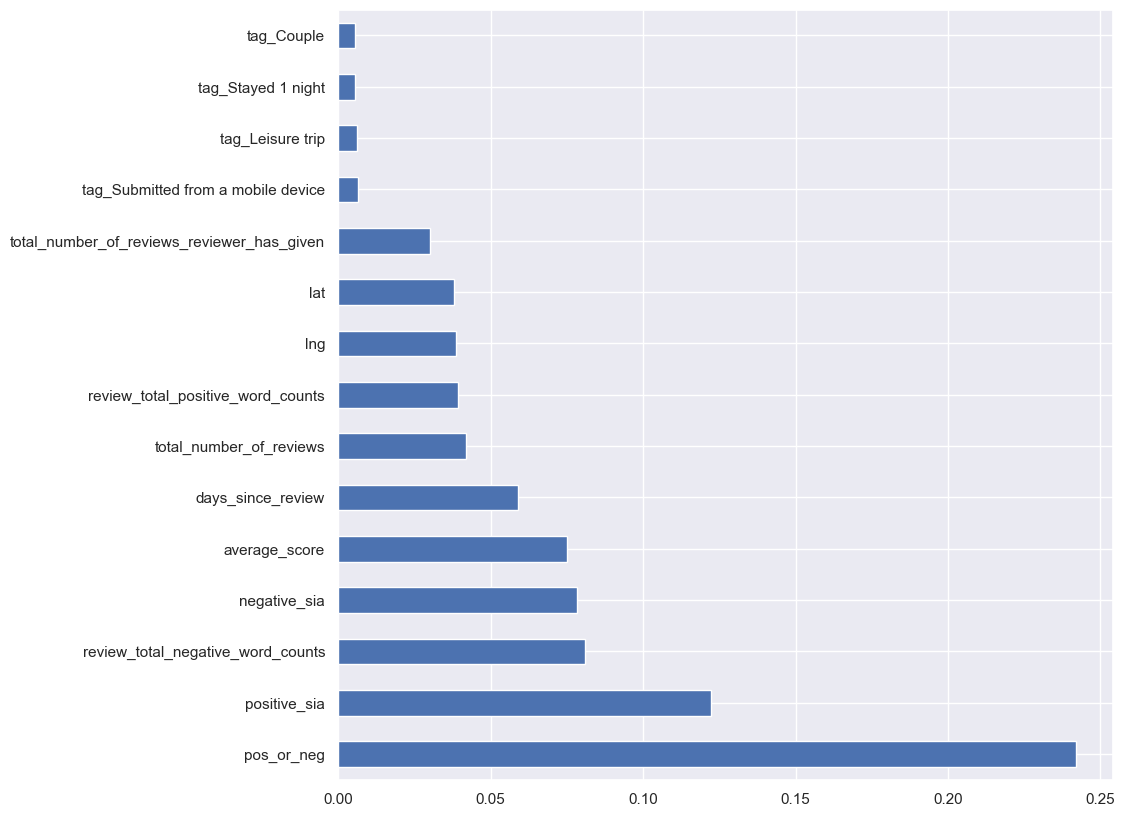

In [89]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [90]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,country_Austria,...,tag_Stayed 4 nights,tag_Double Room,tag_Standard Double Room,tag_Superior Double Room,tag_Family with older children,tag_Deluxe Double Room,tag_Double or Twin Room,tag_Stayed 5 nights,tag_Standard Double or Twin Room,tag_Classic Double Room
404873,-1.285714,-0.047619,1.232201,3.470588,-0.142857,0.0,0.465909,0.004512,-0.036219,False,...,0,1,1,0,0,0,0,0,0,0
478077,0.142857,-0.285714,0.188916,1.294118,0.428571,0.0,0.792614,-1.823173,1.840745,False,...,0,0,0,0,1,0,0,0,0,0
443046,0.857143,-0.047619,0.257282,-0.411765,0.571429,0.0,0.156250,-1.827992,1.843097,False,...,0,0,0,0,0,0,1,0,0,0
430500,0.142857,-0.428571,-0.405744,-0.411765,-0.285714,0.0,0.198864,0.004669,-0.015472,False,...,0,0,0,0,0,0,0,0,0,0
446900,0.285714,-0.095238,-0.530340,-0.647059,1.142857,0.0,-0.767045,-0.796543,0.464388,False,...,0,1,1,0,0,0,0,0,0,0
414254,-0.142857,-0.428571,1.031553,1.294118,0.714286,0.0,-0.528409,-0.002607,-0.028349,False,...,0,1,0,0,0,0,0,0,0,0
435828,0.428571,-0.190476,-0.188511,2.529412,0.285714,0.0,-0.778409,0.003504,-0.018332,False,...,0,1,0,1,0,0,0,0,0,0
420328,-0.428571,-0.428571,-0.339806,0.529412,0.428571,0.0,0.900568,0.008866,-0.037766,False,...,0,1,0,0,0,0,0,0,0,0
456683,-1.000000,0.190476,-0.551375,0.000000,0.000000,0.0,-0.821023,-3.059764,0.437556,False,...,0,0,0,0,0,0,1,0,0,0
458487,-0.285714,-0.428571,0.348706,1.411765,1.000000,0.0,0.235795,0.003881,-0.021002,False,...,0,0,0,0,0,0,0,0,0,0


In [91]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [92]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [93]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [94]:
predict_submission

array([8.687, 7.248, 8.567, ..., 7.928, 9.414, 6.986])

In [95]:
list(sample_submission)

['reviewer_score', 'id']

In [96]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.687,488440
1,7.248,274649
2,8.567,374688
3,9.741,404352
4,9.612,451596
5,8.819,302161
6,8.222,317079
7,8.081,13963
8,8.571,159785
9,7.262,195089
